### Sentiment Analysis for <insert company> messages

Connecting to <insert company> Chatbot Database

In [9]:
import requests
from pprint import pprint
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

sns.set()

# %matplotlib inline

db = pymysql.connect(host='', user='', passwd='', database='', charset='utf8mb4', cursorclass=pymysql.cursors.DictCursor)
cursor1 = db.cursor()
cursor2 = db.cursor()
query = "SHOW DATABASES"
sql = "SHOW TABLES"
cursor1.execute(query)
cursor2.execute(sql)

# Create a cursor object
cursorObject = db.cursor()

messages_Query = "select * from messages"
messages_meta_Query = "select * from messages_meta"

cursorObject.execute(messages_Query)
cursorObject.execute(messages_meta_Query)

messages_df = pd.read_sql(messages_Query, db)
messages_meta_df = pd.read_sql(messages_meta_Query, db)

- Renaming Variables and Data Filtering

In [7]:
messages_new = messages_df.drop(messages_df.columns.difference(['id', 'recipient', 'type']), 1)
messages_meta_new = messages_meta_df.drop(messages_meta_df.columns.difference(['message_id', 'value']), 1)

messages_meta_new.rename(columns={'message_id': 'id'}, inplace=True)

all_messages = pd.merge(messages_new, messages_meta_new, on='id', how='inner')

all_messages = all_messages[all_messages.type == 'text']
all_messages = all_messages[all_messages.recipient == '0000000000000000']

all_messages.rename({'value': 'text'}, axis=1, inplace='true')

all_messages = all_messages.drop(all_messages.columns.difference(['id', 'text']), 1)

all_messages.shape

all_messages.insert(loc=2, column='year_month', value=all_messages['updated_at'].map(lambda x: 100*x.year + x.month))
all_messages.insert(loc=3, column='month', value=all_messages.updated_at.dt.month)
# +1 to make Monday=1.....until Sunday=7
all_messages.insert(loc=4, column='day', value=all_messages.updated_at.dt.dayofweek+1)
all_messages.insert(loc=5, column='hour', value=all_messages.updated_at.dt.hour)

            id                                               text
132465  132466                                  okey. i will wait
66620    66621  but, I don't know how to sign up on this the p...
117212  117213  good eve po. I want to join contest po. pero i...
74480    74481                                How much <insert company> A7
53331    53332                                        J7 pro best
152767  152768                                          Thank you
161244  161245                    Can <insert company> J5 RAM be upgraded?
112941  112942                                         Gear sport
139738  139739  Hi I'm from laguna. Where can I get a gold A7 ...
90388    90389           authorized <insert company> dealers in davao city
88479    88480  Hi, i just wanna know kung paano iconnect yung...
...        ...                                                ...
40962    40963         hai afternoon po magkano po ung <insert company> A7
155912  155913                          

### Subsetting data for the visual representation of a word cloud

In [ ]:
words = all_messages.sample(n=100, frac=None, replace=False, weights=None, random_state=None, axis=0)

messages_meta = words.applymap(str)

print(words)

training_data = messages_meta.to_dict(orient='records')

### API Connection - Filipino translation to English

In [3]:
subscriptionKey = '5a9ca21cde73490e85b3df566791b30d'

base_url = 'https://api.cognitive.microsofttranslator.com'
path = '/translate?api-version=3.0'
params = '&language=fil&to=en'
constructed_url = base_url + path + params

headers = {
    'Ocp-Apim-Subscription-Key': subscriptionKey,
    'Content-type': 'application/json',
    'X-ClientTraceId': str(uuid.uuid4())
}

body = training_data

request = requests.post(constructed_url, headers=headers, json=body)
response = request.json()
pprint(response)
# response = json.dumps(response, sort_keys=True, indent=4, ensure_ascii=False, separators=(',', ': '))
# print(response)

newdict = {}

for k, v in [(key, d[key]) for d in response for key in d]:
    if k not in newdict:
        newdict[k] = [v]
    else:
        newdict[k].append(v)

newdict_1 = newdict.get('detectedLanguage')
newdict = newdict.get('translations')

flat_list = [item for sublist in newdict for item in sublist]

flat_list_1 = pd.DataFrame(newdict_1)
flat_list = pd.DataFrame(flat_list)

print(flat_list_1)
print(flat_list)

flat_list.rename(columns={'to': 'language'}, inplace=True)

flat_list['id'] = range(1, len(flat_list) + 1)

flat_list = flat_list.applymap(str)

sentiment_data = flat_list.to_dict(orient='records')

[{'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': 'Hello good day.', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': 'J7 pro how much?', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': 'I like it', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'fil', 'score': 1.0},
  'translations': [{'text': 'Ayala cebu', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': 'hm po? s7 edge', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': '<insert company> j1 mini prime', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': 'How much is the j4 plus?', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': 'Where to Buy', 'to': 'en'}]},
 {'detectedLanguage': {'language': 'fil', 'sc

In [4]:
subscription_key = '78cdb3e4448c412ca987edc856c4f715'
assert subscription_key

text_analytics_base_url = "https://eastasia.api.cognitive.microsoft.com/text/analytics/v2.0/"

# language_api_url = text_analytics_base_url + "languages"
# print(language_api_url)

# documents = {'documents': training_data}

# headers = {"Ocp-Apim-Subscription-Key": subscription_key}
# response = requests.post(language_api_url, headers=headers, json=documents)
# languages = response.json()
# pprint(languages)

# table = []
# for document in languages["documents"]:
#     text = next(filter(lambda d: d["id"] == document["id"], documents["documents"]))["id"]
#     langs = ", ".join(["{1}".format(lang["name"], lang["iso6391Name"]) for lang in document["detectedLanguages"]])
#     table.append("{0}".format(text, langs))
#     table.append("{1}".format(text, langs))

# df = pd.DataFrame(np.array(table).reshape(-1, 2), columns=list("ab"))

# df.rename({'a': 'id', 'b': 'language'}, axis=1, inplace='true')

# df.drop(df[df.language == '(Unknown)'].index, inplace=True)

# df.to_csv(r'/Users/AF/Downloads/language.txt', header=None, index=None, sep=' ', mode='a')

# df = df.applymap(str)

# print(df)

# new_feedback = pd.merge(df, flat_list, on='id', how='inner')

# sentiment_data = new_feedback.to_dict(orient='records')

https://eastasia.api.cognitive.microsoft.com/text/analytics/v2.0/languages
{'documents': [{'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '1'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '2'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '3'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '4'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
   

               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '77'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '78'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '79'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id': '80'},
               {'detectedLanguages': [{'iso6391Name': 'en',
                                       'name': 'English',
                                       'score': 1.0}],
                'id

In [5]:
sentiment_api_url = text_analytics_base_url + "sentiment"
print(sentiment_api_url)


documents = {'documents': sentiment_data}

headers = {"Ocp-Apim-Subscription-Key": subscription_key}
response = requests.post(sentiment_api_url, headers=headers, json=documents)
sentiments = response.json()
pprint(sentiments)


table = []
for document in sentiments["documents"]:
    text = next(filter(lambda d: d["id"] == document["id"], sentiments["documents"]))["id"]
    phrases = "".join(str(document["score"]))
    table.append("{0}".format(text, phrases))
    table.append("{1}".format(text, phrases))

sentiments_new = pd.DataFrame(np.array(table).reshape(-1, 2), columns=list("ab"))

sentiments_new.rename({'a': 'id', 'b': 'score'}, axis=1, inplace='true')

print(sentiments_new)

sentiments_new.to_csv(r'/Users/AF/Downloads/sentiments_score.txt', header=True, index=None, sep=' ', mode='a')


https://eastasia.api.cognitive.microsoft.com/text/analytics/v2.0/sentiment
{'documents': [{'id': '1', 'score': 0.9893270134925842},
               {'id': '2', 'score': 0.19609335064888},
               {'id': '3', 'score': 0.7739281058311462},
               {'id': '4', 'score': 0.9788496494293213},
               {'id': '5', 'score': 0.5},
               {'id': '6', 'score': 0.5},
               {'id': '7', 'score': 0.7197728157043457},
               {'id': '8', 'score': 0.5},
               {'id': '9', 'score': 0.7510144114494324},
               {'id': '10', 'score': 0.7479833960533142},
               {'id': '11', 'score': 0.7526739239692688},
               {'id': '12', 'score': 0.7526739239692688},
               {'id': '13', 'score': 0.7526739239692688},
               {'id': '14', 'score': 0.2627682685852051},
               {'id': '15', 'score': 0.5},
               {'id': '16', 'score': 0.10843795537948608},
               {'id': '17', 'score': 0.9601994752883911},
         

In [9]:
key_phrase_api_url = text_analytics_base_url + "keyPhrases"
print(key_phrase_api_url)

documents = {'documents': sentiment_data}

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
response = requests.post(key_phrase_api_url, headers=headers, json=documents)
key_phrases = response.json()
pprint(key_phrases)

table = []
for document in key_phrases["documents"]:
    text = next(filter(lambda d: d["id"] == document["id"], key_phrases["documents"]))["id"]
    phrases = ", ".join(document["keyPhrases"])
    table.append("{0}".format(text, phrases))
    table.append("{1}".format(text, phrases))

key_phrases_new = pd.DataFrame(np.array(table).reshape(-1, 2), columns=list("ab"))

key_phrases_new.rename({'a': 'id', 'b': 'keyPhrases'}, axis=1, inplace='true')

print(key_phrases_new)

https://eastasia.api.cognitive.microsoft.com/text/analytics/v2.0/keyPhrases
{'documents': [{'id': '1', 'keyPhrases': ['gb ram variant', 'uprade', 'a7']},
               {'id': '2', 'keyPhrases': ['Camera']},
               {'id': '3', 'keyPhrases': []},
               {'id': '4', 'keyPhrases': ['j6']},
               {'id': '5', 'keyPhrases': ['swap']},
               {'id': '6', 'keyPhrases': ['a7']},
               {'id': '7',
                'keyPhrases': ['J8 <insert company>',
                               'lost phone',
                               'gift',
                               'wife',
                               'month',
                               'security lock',
                               'pickpocket']},
               {'id': '8', 'keyPhrases': []},
               {'id': '9',
                'keyPhrases': ['C9 pro',
                               'j series',
                               'Useless shovel',
                               'unit',
          

In [10]:
# A decimal number between 0 and 1 denoting the sentiment of the document.
# A score above 0.7 usually refers to a positive document while a score below
# 0.3 normally has a negative connotation. Mid values refer to neutral text.

sentiments_new = sentiments_new.applymap(float)


def sentiments(row):
    if row['score'] > float(0.7):
        return 'Positive'
    if row['score'] < float(0.3):
        return 'Negative'
    else:
        return 'Neutral'


sentiments_new['sentiments'] = sentiments_new.apply(lambda row: sentiments(row), axis=1)

print(sentiments_new)

       id     score sentiments
0     1.0  0.259566   Negative
1     2.0  0.500000    Neutral
2     3.0  0.860375   Positive
3     4.0  0.500000    Neutral
4     5.0  0.881760   Positive
5     6.0  0.752674   Positive
6     7.0  0.250371   Negative
7     8.0  0.988292   Positive
8     9.0  0.185473   Negative
9    10.0  0.815652   Positive
10   11.0  0.737677   Positive
11   12.0  0.500000    Neutral
12   13.0  0.729962   Positive
13   14.0  0.796906   Positive
14   15.0  0.926759   Positive
15   16.0  0.500000    Neutral
16   17.0  0.715257   Positive
17   18.0  0.805128   Positive
18   19.0  0.760109   Positive
19   20.0  0.892954   Positive
20   21.0  0.500000    Neutral
21   22.0  0.500000    Neutral
22   23.0  0.739222   Positive
23   24.0  0.768604   Positive
24   25.0  0.888770   Positive
25   26.0  0.775637   Positive
26   27.0  0.849061   Positive
27   28.0  0.500000    Neutral
28   29.0  0.500000    Neutral
29   30.0  0.144573   Negative
..    ...       ...        ...
69   71.

count    99.000000
mean     63.577071
std      25.688889
min       1.470000
25%      50.000000
50%      74.410000
75%      81.640000
max      99.310000
Name: score_percentage, dtype: float64
      id    score sentiments  score_percentage
97  99.0  0.99311   Positive             99.31
[{'id': '4', 'language': 'en', 'text': 'j6+ price'}]
      id     score sentiments  score_percentage
46  48.0  0.014701   Negative              1.47
[]


/Users/AF/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


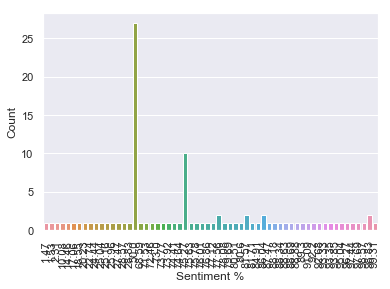

In [11]:
sentiments_new["score_percentage"] = round(sentiments_new.score * 100, 2)
sentiments_new.head()

print(sentiments_new.score_percentage.describe())

max_sentiment = sentiments_new[sentiments_new.score_percentage == sentiments_new.score_percentage.max()]
print(max_sentiment)

print([doc for doc in documents["documents"] if doc["id"] in max_sentiment.index.values])

min_sentiment = sentiments_new[sentiments_new.score_percentage == sentiments_new.score_percentage.min()]
print(min_sentiment)

print([doc for doc in documents["documents"] if doc["id"] in min_sentiment.index.values])

g = sns.countplot(sentiments_new.score_percentage)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=90)
g.set_ylabel("Count")
g.set_xlabel("Sentiment %")

plt.show()


word_cloud = key_phrases_new.drop(key_phrases_new.columns.difference(['keyPhrases']), 1)
sentiments_new = sentiments_new.drop(sentiments_new.columns.difference(['sentiments']), 1)

sentiments_new = pd.merge(word_cloud, sentiments_new, right_index=True, left_index=True)


# word_cloud.to_csv(r'/Users/AF/Downloads/wordcloud.txt', header=None, index=None, sep=' ', mode='a')

# new_feedback = pd.merge(sentiment_data, sentiments_new, on='id', how='inner')
# new_feedback = pd.merge(new_feedback,  key_phrases_new, on='id', how='inner')
#
# writer = pd.ExcelWriter('/Users/AF/Downloads/sentiment.xlsx', engine='xlsxwriter')
# new_feedback.to_excel(writer, sheet_name='Sheet1')
# writer.save()

In [12]:
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

from subprocess import check_output

In [13]:
# Splitting the dataset into train and test set
train, test = train_test_split(sentiments_new,test_size = 0.1)
# Removing neutral sentiments
train = sentiments_new[sentiments_new.sentiments != "Neutral"]

Positive words


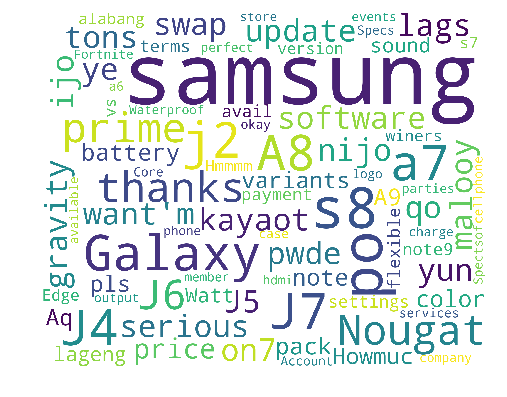

Negative words


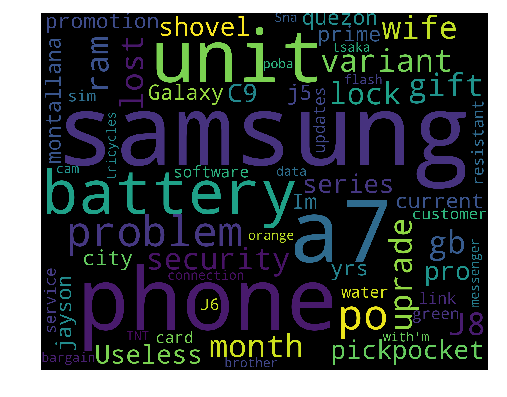

In [14]:
train_pos = train[train['sentiments'] == 'Positive']
train_pos = train_pos['keyPhrases']
train_neg = train[train['sentiments'] == 'Negative']
train_neg = train_neg['keyPhrases']

def wordcloud_draw(train, color = 'black'):
    words = ' '.join(train)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

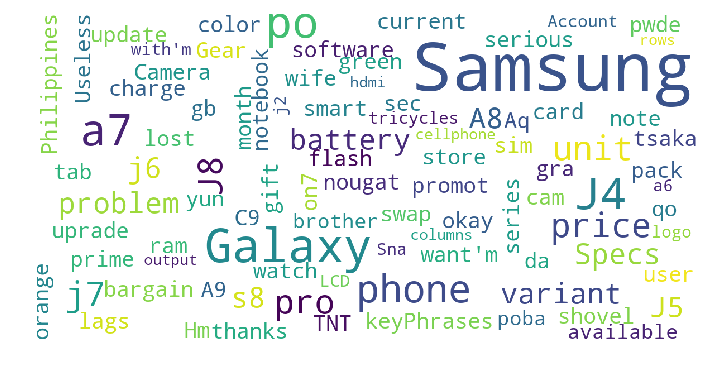

In [15]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
import pandas as pd

text = word_cloud

# Create and generate a word cloud image

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


show_wordcloud(text)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(train.keyPhrases)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
len(cvec.get_feature_names())

132

In [18]:
neg_doc_matrix = cvec.transform(train[train.sentiments == 'Negative'].keyPhrases)
pos_doc_matrix = cvec.transform(train[train.sentiments == 'Positive'].keyPhrases)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
print(term_freq_df)

            0  1
a6          0  1
a7          3  3
a8          0  3
a9          0  1
account     0  1
alabang     0  1
aq          0  1
avail       0  1
available   0  1
bargain     1  0
battery     2  1
brother     1  0
c9          1  0
cam         1  0
card        1  0
case        0  1
cellphone   0  1
charge      0  1
city        1  0
color       0  1
company     0  1
connection  1  0
core        0  1
current     1  0
customer    1  0
data        1  0
edge        0  1
events      0  1
flash       1  0
flexible    0  1
...        .. ..
sound       0  1
specs       0  1
spectsof    0  1
store       0  1
swap        0  1
terms       0  1
thanks      0  2
tnt         1  0
tons        0  1
tricycles   1  0
tsaka       1  0
unit        2  0
update      0  1
updates     1  0
uprade      1  0
useless     1  0
variant     1  0
variants    0  1
version     0  1
vs          0  1
want        0  1
water       1  0
waterproof  0  1
watt        0  1
wife        1  0
winers      0  1
with        1 

In [19]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]
print(term_freq_df)

            negative  positive  total
a6                 0         1      1
a7                 3         3      6
a8                 0         3      3
a9                 0         1      1
account            0         1      1
alabang            0         1      1
aq                 0         1      1
avail              0         1      1
available          0         1      1
bargain            1         0      1
battery            2         1      3
brother            1         0      1
c9                 1         0      1
cam                1         0      1
card               1         0      1
case               0         1      1
cellphone          0         1      1
charge             0         1      1
city               1         0      1
color              0         1      1
company            0         1      1
connection         1         0      1
core               0         1      1
current            1         0      1
customer           1         0      1
data        

Text(0.5,1,'Top 20 tokens in messages')

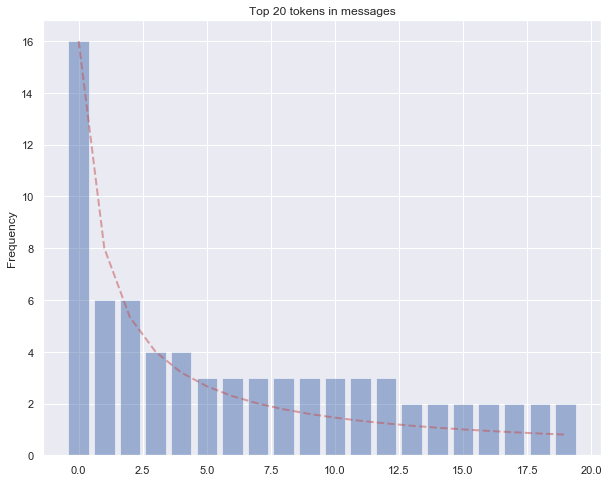

In [20]:
y_pos = np.arange(20)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:20], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 20 tokens in messages')

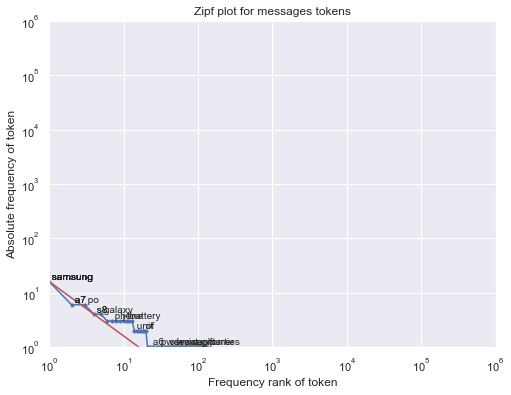

In [21]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for messages tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")


top # words in negative messages in bar chart

Text(0.5,1,'Top 20 tokens in negative messages')

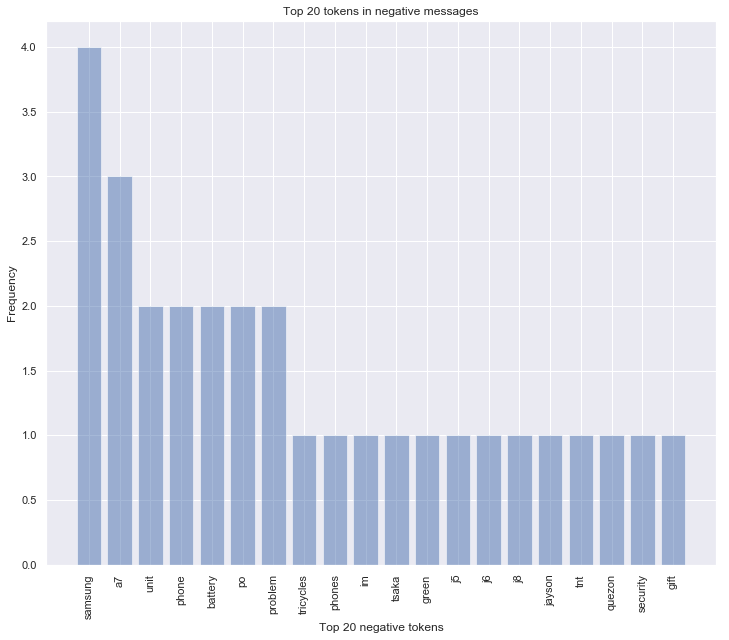

In [22]:
y_pos = np.arange(20)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:20], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:20].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 20 negative tokens')
plt.title('Top 20 tokens in negative messages')

top # words in positive messages in bar chart

Text(0.5,1,'Top 20 tokens in positive messages')

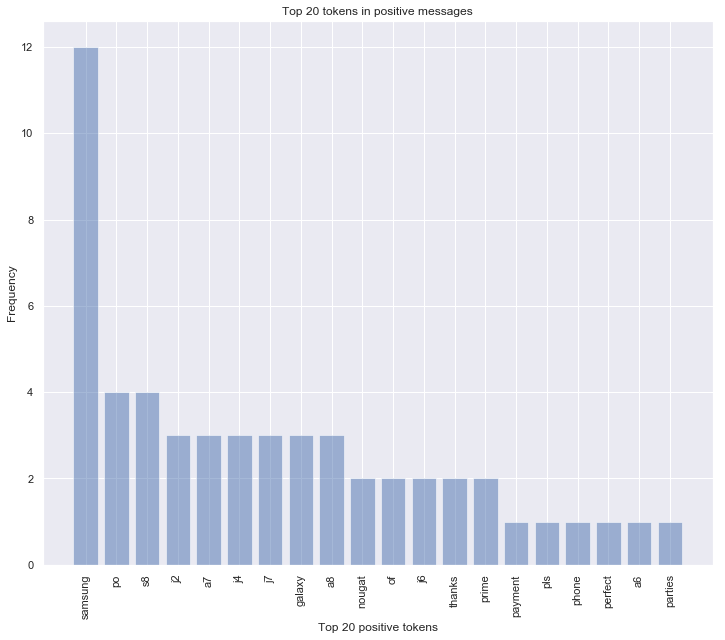

In [23]:
y_pos = np.arange(20)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:20], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:20].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 20 positive tokens')
plt.title('Top 20 tokens in positive messages')

negative frequency of a word on X-axis, and positive frequency on Y-axis

Text(0.5,1,'Negative Frequency vs Positive Frequency')

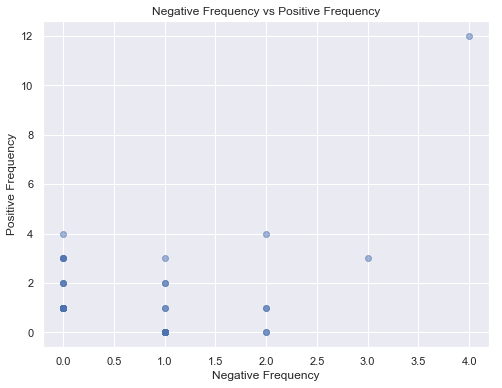

In [24]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [25]:
term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
a6,0,1,1,1.0
s7,0,1,1,1.0
pwde,0,1,1,1.0
price,0,1,1,1.0
pls,0,1,1,1.0
perfect,0,1,1,1.0
payment,0,1,1,1.0
parties,0,1,1,1.0
pack,0,1,1,1.0
output,0,1,1,1.0


In [26]:
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
,4,12,16,0.750000,0.104348
po,2,4,6,0.666667,0.034783
s8,0,4,4,1.000000,0.034783
j2,0,3,3,1.000000,0.026087
a7,3,3,6,0.500000,0.026087
j4,0,3,3,1.000000,0.026087
j7,0,3,3,1.000000,0.026087
galaxy,1,3,4,0.750000,0.026087
a8,0,3,3,1.000000,0.026087
nougat,0,2,2,1.000000,0.017391


In [27]:
from scipy.stats import hmean

term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']]) if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)                                                        
term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
,4,12,16,0.750000,0.104348,0.183206
s8,0,4,4,1.000000,0.034783,0.067227
po,2,4,6,0.666667,0.034783,0.066116
j2,0,3,3,1.000000,0.026087,0.050847
a8,0,3,3,1.000000,0.026087,0.050847
j7,0,3,3,1.000000,0.026087,0.050847
j4,0,3,3,1.000000,0.026087,0.050847
galaxy,1,3,4,0.750000,0.026087,0.050420
a7,3,3,6,0.500000,0.026087,0.049587
thanks,0,2,2,1.000000,0.017391,0.034188


In [28]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
s8,0,4,4,1.00,0.034783,0.067227,0.809866,0.992493,0.891927
a8,0,3,3,1.00,0.026087,0.050847,0.809866,0.951011,0.874782
j7,0,3,3,1.00,0.026087,0.050847,0.809866,0.951011,0.874782
j4,0,3,3,1.00,0.026087,0.050847,0.809866,0.951011,0.874782
j2,0,3,3,1.00,0.026087,0.050847,0.809866,0.951011,0.874782
thanks,0,2,2,1.00,0.017391,0.034188,0.809866,0.809871,0.809868
nougat,0,2,2,1.00,0.017391,0.034188,0.809866,0.809871,0.809868
of,0,2,2,1.00,0.017391,0.034188,0.809866,0.809871,0.809868
,4,12,16,0.75,0.104348,0.183206,0.638380,1.000000,0.779282
galaxy,1,3,4,0.75,0.026087,0.050420,0.638380,0.951011,0.763948


In [29]:
term_freq_df['neg_rate'] = term_freq_df['negative'] * 1./term_freq_df['total']
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] * 1./term_freq_df['negative'].sum()
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])
term_freq_df.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
unit,2,0,2,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.028169,0.054795,0.887946,0.984063,0.933537
problem,2,0,2,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.028169,0.054795,0.887946,0.984063,0.933537
battery,2,1,3,0.333333,0.008696,0.016949,0.302234,0.539871,0.387523,0.666667,0.028169,0.054054,0.697766,0.984063,0.816546
phone,2,1,3,0.333333,0.008696,0.016949,0.302234,0.539871,0.387523,0.666667,0.028169,0.054054,0.697766,0.984063,0.816546
quezon,1,0,1,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.014085,0.027778,0.887946,0.751199,0.813869
jayson,1,0,1,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.014085,0.027778,0.887946,0.751199,0.813869
service,1,0,1,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.014085,0.027778,0.887946,0.751199,0.813869
gift,1,0,1,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.014085,0.027778,0.887946,0.751199,0.813869
green,1,0,1,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.014085,0.027778,0.887946,0.751199,0.813869
tsaka,1,0,1,0.000000,0.000000,0.000000,0.112054,0.249138,0.154582,1.000000,0.014085,0.027778,0.887946,0.751199,0.813869


Text(0.5,1,'neg_hmean vs pos_hmean')

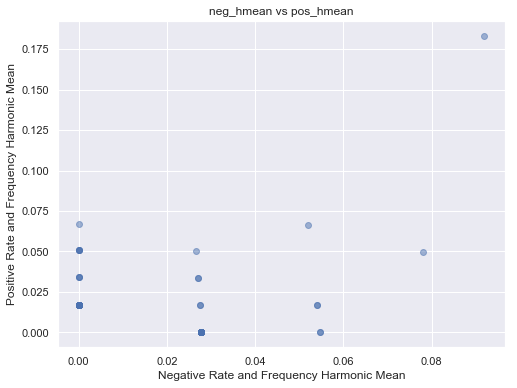

In [30]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5,1,'neg_normcdf_hmean vs pos_normcdf_hmean')

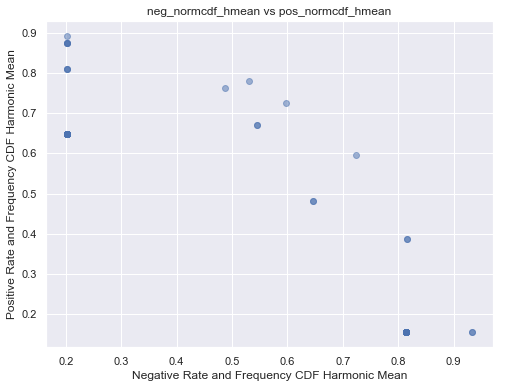

In [31]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [32]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...